# Setup

In [225]:
#!jupyter nbextension enable --py widgetsnbextension

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
import sklearn.metrics as metrics
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xg
import optuna

#from sklearn.experimental import enable_iterative_imputer
#from sklearn.impute import IterativeImputer

sns.set_theme()

In [81]:
df_test = pd.read_csv('./test.csv')
df = pd.read_csv('./train.csv')

df_res = pd.DataFrame()
df_res['PassengerId'] = df_test['PassengerId']

df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


# Feature engeneering

<Axes: xlabel='No_spending', ylabel='count'>

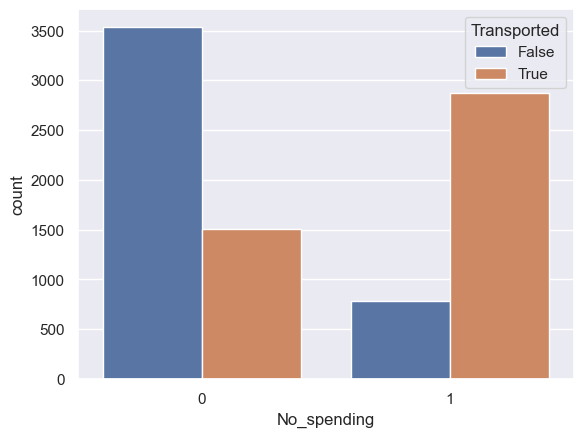

In [228]:
spend_feats = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df['Total_spending'] = df[spend_feats].sum(axis=1)
df['No_spending'] = (df['Total_spending']==0).astype(int)

df_test['Total_spending'] = df_test[spend_feats].sum(axis=1)
df_test['No_spending'] = (df_test['Total_spending']==0).astype(int)

sns.countplot(data=df, x='No_spending', hue='Transported')

In [229]:
#df_pre = pd.concat([df, df_test], axis=0)

In [230]:
def cabin_parse(df):
    df['Cabin'].fillna('np.nan/-1/np.nan',inplace=True)  # можем сплитить nan
    
    df['Cabin_deck'] = df['Cabin'].apply(lambda x: x.split("/")[0]).astype(str)
    df['Cabin_number']  = df['Cabin'].apply(lambda x: x.split("/")[1]).astype(float)
    df['Cabin_side'] = df['Cabin'].apply(lambda x: x.split("/")[2]).astype(str)

    df['Cabin_deck'] = df['Cabin_deck'].replace('np.nan', np.nan) # возвращаем nan обратно
    df['Cabin_number'] = df['Cabin_number'].replace(-1, np.nan)
    df['Cabin_side'] = df['Cabin_side'].replace('np.nan', np.nan)
    return df

In [231]:
#df_pre = cabin_parse(df_pre)
df = cabin_parse(df)
df_test = cabin_parse(df_test)

C:\Users\alibe\AppData\Local\Temp\ipykernel_12568\258522693.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\alibe\AppData\Local\Temp\ipykernel_12568\258522693.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

In [232]:
def Id_parse(df):
    df['Group'] = df['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)   
    df['Group_size']=df['Group'].map(lambda x: df['Group'].value_counts()[x])
    df['Solo']=(df['Group_size']==1).astype(int)
#Id_parse(df_pre)
Id_parse(df)
Id_parse(df_test)

In [233]:
def Name_parse(df):
    df['Name'].fillna('Unknown Unknown', inplace=True)
    
    # New feature - Surname
    df['Surname'] = df['Name'].str.split().str[-1]
    
    # New feature - Family size
    df['Family_size'] = df['Surname'].map(lambda x: df['Surname'].value_counts()[x])
    
    # Put Nan's back in (we will fill these later)
    df.loc[df['Surname']=='Unknown','Surname']=np.nan
    df.loc[df['Family_size']>100,'Family_size']=np.nan
#Name_parse(df_pre)
Name_parse(df)
Name_parse(df_test)

C:\Users\alibe\AppData\Local\Temp\ipykernel_12568\1574064879.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\alibe\AppData\Local\Temp\ipykernel_12568\1574064879.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

# Заполняем пропуски

In [234]:
df_pre = pd.concat([df, df_test], axis=0)

In [235]:
drop_features = ['PassengerId', 'Name', 'Surname', 'Cabin']
#df = df.drop(columns=drop_features)
#df_test = df_test.drop(columns=drop_features)
df_pre = df_pre.drop(columns=drop_features)

## Предсказываем пропуски с lgbm

In [236]:
df_pre.isna().sum()

HomePlanet         288
CryoSleep          310
Destination        274
Age                270
VIP                296
RoomService        263
FoodCourt          289
ShoppingMall       306
Spa                284
VRDeck             268
Transported       4277
Total_spending       0
No_spending          0
Cabin_deck         299
Cabin_number       299
Cabin_side         299
Group                0
Group_size           0
Solo                 0
Family_size        200
dtype: int64

### Пропуски в категориальных фичах

In [237]:
def fill_cat_nan_setup(df, target_name, test=False):
    cat_features = ['CryoSleep', 'No_spending', 'VIP',  'Destination', 'HomePlanet', 'Family_size', 'Cabin_side', 'Cabin_deck']
    cat_features.remove(target_name)
    df_copy = df
    if not test:
        df_copy = df_copy.drop(columns=['Transported'])
    
    mask = df_copy[target_name].isna()
    df_test_nan = df_copy[mask]
    df_copy = df_copy.dropna(subset=[target_name])
    labelencoder = LabelEncoder()
    for f in cat_features:
        #df_copy[f] = labelencoder.fit_transform(df_copy[f])
        df_copy[f] = df_copy[f].astype('category')
        df_test_nan[f] = df_test_nan[f].astype('category')
    df_copy[target_name] = labelencoder.fit_transform(df_copy[target_name])
    df_copy[target_name] = df_copy[target_name].astype('int')
    return df_copy, df_test_nan, mask, labelencoder
#target = df_copy[target_name] # for validation
#target = df_copy.loc[:,target_name]
#df_copy['HomePlanet'].value_counts()

HomePlanet 0.9525444538497322

Destination 0.6899299846196627

CryoSleep 0.9485797625846104

No_spending 1?

VIP 0.9771080558314601

Cabin_side 0.4949384069198885

Cabin_deck 0.5414215803517763

Family_size 0.9348828487068191


In [238]:
def train_model_cat(train, test, target_name):
    cat_features = ['CryoSleep', 'No_spending', 'VIP',  'Destination', 'HomePlanet', 'Family_size', 'Cabin_side', 'Cabin_deck', 'Group_size', 'Solo']
    cat_features.remove(target_name)
    X_train = train.drop([target_name], axis=1)
    y_train = train[target_name]
    X_test = test.drop([target_name], axis=1)
    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    num_class = len(y_train.unique())
    params = {
        'objective': 'multiclass',
        'num_class': num_class,
        'boosting_type': 'gbdt',  
        'metric': 'multi_logloss',
        'verbose': 0
    }    
    num_round = 10
    model = lgb.train(params, train_data, num_round)
    y_pred = model.predict(X_test)#, num_iteration=model.best_iteration)
    y_pred = np.argmax(y_pred, axis=1)
    return y_pred

In [239]:
def fill_nan_cat(df, test=False):
    target_cat_features = ['VIP', 'HomePlanet', 'CryoSleep', 'Family_size', 'Destination', 'Cabin_deck', 'Cabin_side']
    for f in target_cat_features:
        if (test) & (f == 'Family_size'):
            continue
        df_copy, df_test_nan, mask, labelencoder = fill_cat_nan_setup(df, f, test)
        y_pred = train_model_cat(df_copy, df_test_nan, f)
        y_pred = labelencoder.inverse_transform(y_pred)
        df.loc[mask, f] = y_pred
        print(f, 'filled')


In [240]:
#fill_nan_cat(df)
#df.isna().sum()
fill_nan_cat(df_pre)
df_pre.isna().sum()

VIP filled
HomePlanet filled
CryoSleep filled
Family_size filled
Destination filled
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Cabin_deck filled
Cabin_side filled


HomePlanet           0
CryoSleep            0
Destination          0
Age                270
VIP                  0
RoomService        263
FoodCourt          289
ShoppingMall       306
Spa                284
VRDeck             268
Transported       4277
Total_spending       0
No_spending          0
Cabin_deck           0
Cabin_number       299
Cabin_side           0
Group                0
Group_size           0
Solo                 0
Family_size          0
dtype: int64

### Пропуски в численных фичах

In [241]:
def fill_cont_nan_setup(df, target_name, test=False):
    cat_features = ['CryoSleep', 'No_spending', 'VIP',  'Destination', 'HomePlanet', 'Family_size', 'Cabin_side', 'Cabin_deck', 'Group_size', 'Solo']
    #cont_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Cabin_number']
    #cont_features.remove(target_name)
    df_copy = df
    if not test:
        df_copy = df_copy.drop(columns=['Transported'])
    for f in cat_features:
        df_copy[f] = df_copy[f].astype('category')
    mask = df_copy[target_name].isna()
    df_test_nan = df_copy[mask]
    df_copy = df_copy.dropna(subset=[target_name])
    return df_copy, df_test_nan, mask

In [242]:
def train_model_cont(train, test, target_name):
    cat_features = ['CryoSleep', 'No_spending', 'VIP',  'Destination', 'HomePlanet', 'Family_size', 'Cabin_side', 'Cabin_deck']
    X_train = train.drop([target_name], axis=1)
    y_train = train[target_name]
    X_test = test.drop([target_name], axis=1)
    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    params = {
        'task': 'train', 
        'boosting': 'gbdt',
        'objective': 'regression',
        'num_leaves': 10,
        'learnnig_rage': 0.3,
        'metric': {'l2','l1'},
        'verbose': -1
    }
    num_round = 100
    model = lgb.train(params, train_data, num_round)
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    #y_pred = np.argmax(y_pred, axis=1)
    return y_pred

In [243]:
def fill_nan_cont(df, test=False):
    target_cont_features = ['Cabin_number', 'FoodCourt', 'VRDeck', 'Spa', 'RoomService',  'ShoppingMall', 'Age',]
    for f in target_cont_features:
        df_copy, df_test_nan, mask = fill_cont_nan_setup(df, f, test)
        y_pred = train_model_cont(df_copy, df_test_nan, f)
        df.loc[mask, f] = y_pred
#fill_nan_cont(df)
fill_nan_cont(df_pre)

In [244]:
df_pre.isna().sum()

HomePlanet           0
CryoSleep            0
Destination          0
Age                  0
VIP                  0
RoomService          0
FoodCourt            0
ShoppingMall         0
Spa                  0
VRDeck               0
Transported       4277
Total_spending       0
No_spending          0
Cabin_deck           0
Cabin_number         0
Cabin_side           0
Group                0
Group_size           0
Solo                 0
Family_size          0
dtype: int64

## Пересчет заинженеренных фич с затратами

In [245]:
spend_feats = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

df_pre['Total_spending'] = df_pre[spend_feats].sum(axis=1)
df_pre['No_spending'] = (df_pre['Total_spending']==0).astype(int)

# df['Total_spending'] = df[spend_feats].sum(axis=1)
# df['No_spending'] = (df['Total_spending']==0).astype(int)

# df_test['Total_spending'] = df_test[spend_feats].sum(axis=1)
# df_test['No_spending'] = (df_test['Total_spending']==0).astype(int)

In [246]:
train_idx = df_pre['Transported'].isnull()
df = df_pre.loc[~train_idx]
df_test = df_pre.loc[train_idx]
df_test = df_test.drop(columns=['Transported'])

In [247]:
df_test

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Total_spending,No_spending,Cabin_deck,Cabin_number,Cabin_side,Group,Group_size,Solo,Family_size
0,Earth,True,TRAPPIST-1e,27.000000,False,0.0,0.0,0.0,0.0,0.0,0.0,1,G,3.00000,S,13,1,1,4.0
1,Earth,False,TRAPPIST-1e,19.000000,False,0.0,9.0,0.0,2823.0,0.0,2832.0,0,F,4.00000,S,18,1,1,1.0
2,Europa,True,55 Cancri e,31.000000,False,0.0,0.0,0.0,0.0,0.0,0.0,1,C,0.00000,S,19,1,1,1.0
3,Europa,False,TRAPPIST-1e,38.000000,False,0.0,6652.0,0.0,181.0,585.0,7418.0,0,C,1.00000,S,21,1,1,1.0
4,Earth,False,TRAPPIST-1e,20.000000,False,10.0,0.0,635.0,0.0,0.0,645.0,0,F,5.00000,S,23,1,1,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,Earth,True,TRAPPIST-1e,34.000000,False,0.0,0.0,0.0,0.0,0.0,0.0,1,G,1496.00000,S,9266,2,0,4.0
4273,Earth,False,TRAPPIST-1e,42.000000,False,0.0,847.0,17.0,10.0,144.0,1018.0,0,T,288.03903,S,9269,1,1,2.0
4274,Mars,True,55 Cancri e,31.286592,False,0.0,0.0,0.0,0.0,0.0,0.0,1,D,296.00000,P,9271,1,1,4.0
4275,Europa,False,TRAPPIST-1e,34.861180,False,0.0,2680.0,0.0,0.0,523.0,3203.0,0,D,297.00000,P,9273,1,1,5.0


## Scaling

In [248]:
for f in ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Total_spending']:
    df[f]=np.log(1+df[f])
    df_test[f]=np.log(1+df_test[f])

C:\Users\alibe\AppData\Local\Temp\ipykernel_12568\1180700960.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\programs\miniforge\envs\env1\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

invalid value encountered in log



In [249]:
df.to_csv('df_train_ready.csv', index=False)
df_test.to_csv('df_test_ready.csv', index=False)

# Моделирование

In [2]:
df = pd.read_csv('./df_train_ready.csv')
df_test = pd.read_csv('./test.csv')
df_res = pd.DataFrame()
df_res['PassengerId'] = df_test['PassengerId']
df_test = pd.read_csv('./df_test_ready.csv')

target = 'Transported'
#X_train = df.drop(columns=[target]) maybe uncomment later
X_train = df
y_train = df[target]
X_test = df_test
cat_features = ['CryoSleep', 'Destination', 'HomePlanet', 'Family_size', 'Cabin_side', 'Cabin_deck', 'Group_size', 'No_spending', 'VIP', 'Solo']
X_train[cat_features] = X_train[cat_features].astype(str)
X_test[cat_features] = X_test[cat_features].astype(str)

In [177]:
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Catboost tuning

In [167]:
def objective(trial):
    params = {
        "loss_function":'Logloss', # objective function
        'eval_metric':'AUC', # metric
        #"iterations": trial.suggest_int("iterations", 500, 3000),
        'iterations': 1000,
        'use_best_model': True,
        'early_stopping_rounds': 100,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.15, log=True),
        "depth": trial.suggest_int("depth", 5, 12),
        #"boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        #"bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "boosting_type": "Ordered",
        "bootstrap_type": "MVS",
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 300),
    }

    # if params["bootstrap_type"] == "Bayesian":
    #     params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 15)
    # elif params["bootstrap_type"] == "Bernoulli":
    #     params["subsample"] = trial.suggest_float("subsample", 0.1, 1.0)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=43)
    loss = []
    accs = []
    trees = []
    model = CatBoostClassifier(**params, silent=True)
    for train_index, test_index in skf.split(X_train, y_train):
        train = X_train.iloc[train_index,:]
        test = X_train.iloc[test_index,:]
        Xtrain = train.drop([target], axis=1)
        ytrain = train[target]
        Xval = test.drop([target], axis=1)
        yval = test[target]
        model.fit(Xtrain, ytrain, eval_set=(Xval, yval) ,cat_features=cat_features)
        predictions = model.predict(Xval)
        probability_predictions = model.predict_proba(Xval)
        log_loss = metrics.log_loss(yval, probability_predictions[:,1])
        acc = metrics.accuracy_score(yval.astype(str), predictions)
        accs.append(acc)
        loss.append(log_loss)
        trees.append(model.tree_count_)
        #print("Count of trees in model = {}".format(model.tree_count_))

    mean_loss = np.mean(loss)
    median_loss = np.median(loss)
    mean_acc = np.mean(accs)
    median_acc = np.median(accs)
    mean_trees = np.mean(trees)
    print('Accuracy:', np.min([mean_acc, median_acc]), ', Trees:', mean_trees)
    return np.max([mean_loss, median_loss])
    #return np.min([mean_acc, median_acc])

In [227]:
y_train[test_index]

0       False
1        True
2       False
3       False
4        True
        ...  
2349     True
2351     True
2353     True
2355     True
2359     True
Name: Transported, Length: 2174, dtype: bool

(100 iter)Best hyperparameters: {'learning_rate': 0.08855177832272393, 'depth': 5, 'subsample': 0.723087169000773, 'colsample_bylevel': 0.43913003452488014, 'min_data_in_leaf': 27}

Best hyperparameters: {'iterations': 1215, 'learning_rate': 0.01357327759616865, 'depth': 7, 'subsample': 0.7816874205544019, 'colsample_bylevel': 0.8131465523259107, 'min_data_in_leaf': 84}
Best log_loss: 0.3900008113810382

[I 2024-02-22 13:47:21,490] Trial 15 finished with value: 0.38174134348266986 and parameters: {'iterations': 1938, 'learning_rate': 0.01310406540250418, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'colsample_bylevel': 0.40507718640418505, 'min_data_in_leaf': 72}. Best is trial 15 with value: 0.38174134348266986.

Best hyperparameters: {'iterations': 1621, 'learning_rate': 0.04080567185240489, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'colsample_bylevel': 0.05099234159706104, 'min_data_in_leaf': 89, 'bagging_temperature': 9.188834830628645}
Best log_loss: 0.4552177666434842

Best hyperparameters: {'learning_rate': 0.027735295304581513, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'colsample_bylevel': 0.55306785843524, 'min_data_in_leaf': 97}
Best log_loss: 0.3810156792466396

[I 2024-02-23 13:17:52,751] Trial 5 finished with value: 0.37613308877119783 and parameters: {'learning_rate': 0.021089661713664304, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'colsample_bylevel': 0.6204306506902849, 'min_data_in_leaf': 78}. Best is trial 5 with value: 0.37613308877119783.
Accuracy: 0.818704147663962
score: ~0.804

[I 2024-02-23 20:01:32,683] Trial 63 finished with value: 0.376673138489069 and parameters: {'learning_rate': 0.03278804846761883, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'colsample_bylevel': 0.9392040381210764, 'min_data_in_leaf': 150}. Best is trial 63 with value: 0.376673138489069.
Accuracy: 0.81656124209315
score: ~0.805

[I 2024-02-24 12:52:30,718] Trial 11 finished with value: 0.37722681337443226 and parameters: {'learning_rate': 0.04505588516491369, 'depth': 12, 'colsample_bylevel': 0.964262259559453, 'min_data_in_leaf': 92}. Best is trial 11 with value: 0.37722681337443226.
Accuracy: 0.8154111558366878 , Trees: 704.67
6536

params = {'loss_function':'Logloss', # objective function
          'eval_metric':'AUC', # metric
          #'verbose': 200, # output to stdout info about training process every 200 iterations
          'use_best_model': True,
          'early_stopping_rounds': 100,
          'iterations': 1000,
          'learning_rate': 0.021089661713664304, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'colsample_bylevel': 0.6204306506902849, 'min_data_in_leaf': 78
         }
1 accuracy: 0.824036802760207 loss: 0.36648893174716696 trees: 844
2 accuracy: 0.8217366302472685 loss: 0.3726503916500332 trees: 1000
3 accuracy: 0.8090856814261069 loss: 0.3918423419212358 trees: 999
4 accuracy: 0.8112773302646721 loss: 0.37887277890081617 trees: 1000
5 accuracy: 0.8043728423475259 loss: 0.38482144086893694 trees: 995
Accuracy: 0.8112773302646721 , Trees: 

Learning rate set to 0.018791(from iter 10000)
1 accuracy: 0.8102357676825762 loss: 0.3704110813552173 trees: 1929
2 accuracy: 0.8257619321449109 loss: 0.3664616125880919 trees: 1562
3 accuracy: 0.8251868890166763 loss: 0.37213388785526275 trees: 1799
4 accuracy: 0.8164556962025317 loss: 0.3897013117548789 trees: 1381
5 accuracy: 0.806674338319908 loss: 0.39150753133190336 trees: 972
  Accuracy: 0.8164556962025317 , Trees: 1528.6967.6

In [5]:
def cat_prepare_data(X):
    cat_features = ['CryoSleep', 'Destination', 'HomePlanet', 'Family_size', 'Cabin_side', 'Cabin_deck', 'Group_size', 'No_spending', 'VIP', 'Solo']
    X[cat_features] = X[cat_features].astype(str)
    return X

In [27]:
def cat_best_train(X_train, y_train):
    cat_features = ['CryoSleep', 'Destination', 'HomePlanet', 'Family_size', 'Cabin_side', 'Cabin_deck', 'Group_size', 'No_spending', 'VIP', 'Solo']
    X_train = cat_prepare_data(X_train)
    params = {'loss_function':'Logloss', # objective function
          'eval_metric':'AUC', # metric
          #'verbose': 200, # output to stdout info about training process every 200 iterations
          'random_seed': 42,
          #'early_stopping_rounds': 200,
          'iterations': 1800,
          'learning_rate': 0.018791,
          #'boosting_type': 'Ordered',
          #'bootstrap_type': 'MVS',
          #'learning_rate': 0.04505588516491369, 'depth': 12, 'colsample_bylevel': 0.964262259559453, 'min_data_in_leaf': 92
         }

    model_cat = CatBoostClassifier(**params, silent=True)
    model_cat.fit(X_train, y_train, 
                  cat_features=cat_features,
              #eval_set=(X_valid, y_valid),
              #use_best_model=True, 
              #plot=True
             )
    return model_cat

In [10]:
def cat_predict(model_cat, X):
    y_pred_cat = model_cat.predict_proba(cat_prepare_data(X))
    return y_pred_cat

## LightGBM tuning

In [ ]:
#dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
#dval = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_features).construct()
#dtest = lgb.Dataset(X_test, label=y_test, categorical_feature=cat_features).construct()

In [ ]:
%%time
study = optuna.create_study(direction='minimize')
study.optimize(objective_lgb, n_trials=200)

[I 2024-02-24 10:03:46,162] Trial 130 finished with value: 0.3797828219469388 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.005289215674609688, 'num_leaves': 9, 'max_depth': 7, 'min_child_samples': 6, 'bagging_freq': 0, 'pos_bagging_fraction': 0.871208206878925, 'neg_bagging_fraction': 0.5686406568147586, 'reg_alpha': 0.00163033289890992, 'reg_lambda': 6.346074272234815e-05}. Best is trial 130 with value: 0.3797828219469388.
Accuracy: 0.8126087966378837 , Trees: 3485.4

## XGBoost Tuning

[I 2024-02-24 23:46:26,254] Trial 33 finished with value: 0.3823012019378098 and parameters: {'n_estimators': 414, 'booster': 'dart', 'lambda': 7.257906464613727e-07, 'alpha': 0.32295704031406347, 'max_depth': 5, 'eta': 0.12309653187593382, 'gamma': 1.3623703493366683e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 8.765541958764515e-08, 'skip_drop': 6.029305745118425e-07}. Best is trial 33 with value: 0.3823012019378098.
Accuracy: 0.8113858539390454 , Trees: 133.

[I 2024-02-25 06:54:30,651] Trial 48 finished with value: 0.3860618257594459 and parameters: {'lambda': 0.0019522595113375008, 'alpha': 1.9456993302676008e-08, 'max_depth': 4, 'eta': 0.056225857149190685, 'gamma': 1.5094193253494852e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.007060129839297592, 'skip_drop': 0.00013724497029676743}. Best is trial 48 with value: 0.3860618257594459.
Accuracy: 0.816288278582919 , Trees: 382.

[I 2024-02-25 08:04:19,425] Trial 55 finished with value: 0.3855543877631223 and parameters: {'lambda': 0.0003406766966351579, 'alpha': 1.9987222568396913e-08, 'max_depth': 4, 'eta': 0.05718822119200016, 'gamma': 9.924235273795815e-09, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.013495712308960836, 'skip_drop': 0.04277472541305154}. Best is trial 55 with value: 0.3855543877631223.
Accuracy: 0.8155971680614826 , Trees: 407.

[I 2024-02-25 09:35:29,642] Trial 69 finished with value: 0.38422769275082097 and parameters: {'lambda': 0.0007225026667028657, 'alpha': 3.8627414977658966e-08, 'max_depth': 5, 'eta': 0.07990837326989136, 'gamma': 6.568408596524987e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.00465925856296986, 'skip_drop': 0.07003038075772171}. Best is trial 69 with value: 0.38422769275082097.
Accuracy: 0.8128368287000122 , Trees: 203.2280

## Stacking

# Submission

In [298]:
pred_save = y_pred_cat

In [28]:
df = pd.read_csv('./df_train_ready.csv')
df_test = pd.read_csv('./test.csv')
df_res = pd.DataFrame()
df_res['PassengerId'] = df_test['PassengerId']
X_test = pd.read_csv('./df_test_ready.csv')
y_train = df['Transported']
X_train = df.drop(columns=['Transported'])

model_cat = cat_best_train(X_train, y_train)
X_test_cat = cat_prepare_data(X_test)

In [31]:
original = 4378 / 4315
print(original)
result = 2187 / 2090
print(result)

1.0146002317497103
1.0464114832535885


In [32]:
x = (2187 - 1.0146 * 2090) / 2.0146
print(x)
print(2187 - x, 2090 + x)

33.00208478109815
2153.9979152189017 2123.0020847810983


In [10]:
y_train.value_counts()

Transported
True     4378
False    4315
Name: count, dtype: int64

In [52]:
model_cat.set_probability_threshold(0.5045)
y_pred_cat = model_cat.predict(X_test_cat)#[:, 1]
(pd.DataFrame(y_pred_cat)).value_counts()

0    
True     2167
False    2110
Name: count, dtype: int64

In [53]:
model_cat.set_probability_threshold(0.5045)
y_pred_cat = model_cat.predict(X_test_cat)#[:, 1]
df_res['Transported'] = y_pred_cat
df_res.to_csv('res_cat.csv', index=False)
df_res

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,True
4274,9271_01,True
4275,9273_01,True


## Feature Importance